# House Prices data from Kaggle

Based on [housing data from Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) and the great O'Reilly book [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) from Aurélien Géron, with its [detailed examples](https://github.com/ageron/handson-ml).

*Todo* improve with steps from [tutorials in Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#tutorials).

In [1]:
import re
import numpy as np
from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder
%matplotlib inline

In [2]:
HOUSING_DATA_PATH = Path("datasets/housing")

def load_housing_data(path=HOUSING_DATA_PATH):
    for name in ("train", "test"):
        csv_path = path / f"{name}.csv"
        yield pd.read_csv(csv_path)

train, test = load_housing_data()
train.shape, test.shape

((1460, 81), (1459, 80))

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Variables definitions without categories.

In [5]:
with open(HOUSING_DATA_PATH / "data_description.txt") as f:
    print(''.join(line for line in f if not line[0].isspace()))

MSSubClass: Identifies the type of dwelling involved in the sale.	
MSZoning: Identifies the general zoning classification of the sale.
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to various conditions
Condition2: Proximity to various conditions (if more than one is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Rates the overall material and finish of the house
OverallCond: Rates the overall condition of the house
YearBuilt: Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
RoofStyle: Type of roof
RoofMatl: Roof material
Ext

# Data cleaning

Extract categories from data description in [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [6]:
def removeNA(v):
    """Remove NA from categories, always in last position."""
    return v[:-1] if v[-1] == 'NA' else v

def extract_cat(descr_string):
    """Extract categories, except NA, from data_description."""
    categories = {m.group(1): re.findall(r'([a-zA-Z0-9.]+).+$', m.group(2), re.MULTILINE)
              for m in re.finditer(r'^(\w+).*\n[ \t]*\n((?:[ \t]+.+\n)+)', descr_string, re.MULTILINE)}
    return {c: CategoricalDtype(categories=removeNA(v), ordered=True) for (c, v) in categories.items()}
    

class Categorizer(BaseEstimator, TransformerMixin):
    """Cast to pandas categories after correcting values."""
    def __init__(self, replace_dict=None, catcols_dict=None):
        self.replace_dict = replace_dict if not replace_dict else {}
        if catcols_dict:
            self.catcols_dict = catcols_dict
        else:
            with open(HOUSING_DATA_PATH / "data_description.txt") as f:
                self.catcols_dict = extract_cat(f.read())
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = (X.replace(self.replace_dict)
             .astype(str) # for int64 values
             .apply(lambda s: pd.Categorical(s, dtype=self.catcols_dict[s.name])))
        return X
    
categorizer = Categorizer()

In [7]:
def no_enc_errors(df):
    """Find potential encoding errors in DataFrame with respect to data_description."""
    ok = True
    for col in df:
        s = df[col]
        cat = categorizer.catcols_dict[col].categories
        diff = pd.Categorical(s).categories.difference(cat)
        if diff.any():
            print(f"{col}: {diff.tolist()}, {cat.tolist()}".format(col, diff))
            ok = False
    return ok

no_enc_errors(train.select_dtypes(exclude=['int64', 'float64']))

MSZoning: ['C (all)'], ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']
Neighborhood: ['NAmes'], ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
BldgType: ['2fmCon', 'Duplex', 'Twnhs'], ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']
RoofMatl: ['Tar&Grv'], ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar', 'WdShake', 'WdShngl']
Exterior1st: ['Wd Sdng'], ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd', 'WdShing']
Exterior2nd: ['Brk Cmn', 'CmentBd', 'Wd Sdng', 'Wd Shng'], ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd', 'WdShing']


False

In [8]:
fix_catencoding = {'MSZoning': {'C (all)': 'C'},
                   'Neighborhood': {'NAmes': 'Names'},
                   'BldgType': {'2fmCon': '2FmCon', 'Duplex': 'Duplx', 'Twnhs': 'TwnhsI'},
                   'RoofMatl': {'Tar&Grv': 'Tar'},
                   'Exterior1st': {'Wd Sdng': 'Wd'},
                   'Exterior2nd': {'Brk Cmn': 'BrkComm', 'CmentBd': 'CemntBd', 'Wd Sdng': 'Wd', 'Wd Shng': 'Wd'}
                  }

Missing values

In [9]:
categorizer = Categorizer(replace_dict=fix_catencoding)

In [10]:
def missing_frac(df):
    m = df.isnull().sum()
    return m[m > 0].sort_values(ascending=False)

missing = pd.concat({'train': missing_frac(train), 'test': missing_frac(test)}, axis=1)
missing_cols = missing.index
missing

,test,train
Alley,1352.0,1369.0
BsmtCond,45.0,37.0
BsmtExposure,44.0,38.0
BsmtFinSF1,1.0,NaN
BsmtFinSF2,1.0,NaN
BsmtFinType1,42.0,37.0
BsmtFinType2,42.0,38.0
BsmtFullBath,2.0,NaN
BsmtHalfBath,2.0,NaN
BsmtQual,44.0,37.0


In [11]:
class DFSelector(BaseEstimator, TransformerMixin):
    """Select columns from DataFrame and return DataFrame."""
    def __init__(self, cols, dropna=False):
        self.cols = cols
        self.dropna = dropna
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols].dropna(axis=1) if self.dropna else X[self.cols]

    
class Encoder(BaseEstimator, TransformerMixin):
    """Encode categories."""
    def __init__(self, method='onehot'):
        self.method = method
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X) if self.method == 'onehot' else X
    

class CatImputer(BaseEstimator, TransformerMixin):
    """Imputer missing categorical values in DataFrame."""
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.strategy == 'most_frequent':
            return X.apply(lambda s: s.fillna(s.value_counts().index[0]))
        else:
            return X

Set aside a test set.

In [12]:
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)
prices = train_set["SalePrice"]
housing = train_set.drop("SalePrice", axis=1)
columns = housing.columns

In [13]:
cat_cols = list(categorizer.catcols_dict)
num_cols = columns.difference(categorizer.catcols_dict)

cat_pipeline = Pipeline([('selector', DFSelector(cat_cols)),
                         ('categorizer', categorizer),
                        ('imputer', CatImputer()),
                        ('encoder', Encoder())])
num_pipeline = Pipeline([('selector', DFSelector(num_cols)),
                        ('imputer', Imputer(strategy='median'))])

full_pipeline = FeatureUnion([
    ('cat_pipeline', cat_pipeline),
    ('num_pipeline', num_pipeline)])

In [14]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(1168, 340)

# Models

Target

In [15]:
prices.head()

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

Price distribution is heavy-tailed, to be transformed with `log`. 

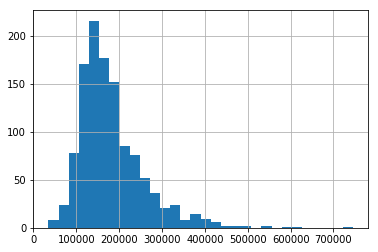

In [16]:
prices.hist(bins=30);

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [18]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
forest_reg = RandomForestRegressor(random_state=42)

In [19]:
scores = cross_val_score(lin_reg, housing_prepared, prices,
                         scoring="neg_mean_squared_error", cv=10)
np.sqrt(-scores)

array([373760.80515657,  33188.5408567 ,  22639.85624943,  50388.67825115,
        63808.78132231,  27698.08391194,  48455.70565128,  21285.78422212,
        48874.34142607,  23756.04682059])

In [20]:
prices_test = test_set.SalePrice
housing_test = test_set.drop("SalePrice", axis=1)

housing_test_trans = full_pipeline.transform(housing_test)
housing_test_trans.shape

(292, 340)

In [21]:
for name, model in [('linear', lin_reg), ('tree', tree_reg), ('forest', forest_reg)]:
    model.fit(housing_prepared, prices)
    pred = model.predict(housing_test_trans)
    score = np.sqrt(mean_squared_error(pred, prices_test))
    print(f'{name}: {score:.2f}')

linear: 36062.77
tree: 40294.25
forest: 31935.32


In [22]:
for name, model in [('linear', lin_reg), ('tree', tree_reg), ('forest', forest_reg)]:
    model.fit(housing_prepared, prices)
    pred = model.predict(housing_test_trans)
    score = np.sqrt(mean_squared_log_error(pred, prices_test))
    print(f'{name}: {score:.2f}')

linear: 0.22
tree: 0.22
forest: 0.17


# Submission

In [26]:
pipeline_with_predict = Pipeline([('preparation', full_pipeline),
                                 ('forest', RandomForestRegressor())])
pipeline_with_predict.fit(housing, prices)
results = pd.DataFrame({'Id': test.Id, 'SalePrice': pipeline_with_predict.predict(test)})
results.to_csv(HOUSING_DATA_PATH / 'submission.csv', index=False)
results.head()

,Id,SalePrice
0,1461,122465.0
1,1462,147990.0
2,1463,176550.0
3,1464,187087.5
4,1465,206732.7
